# Servername analysis

Top1m CF Domains (total=1004235)> 31: 0.310983
	Mean = 13.956636
	Std = 4.486180
Benign Servernames (total=8424)> 31: 5.911681
	CTU normal dataset, total number of TLS flows (using zeek) = 22351
	CTU normal dataset, total number of distinct TLS SNI DNS hostname (using zeek) = 8424
	Mean = 20.276947
	Std = 8.510502
Botnet (CTU) Servernames (total=2911)> 31: 15.973892
	Botnet (CTU) dataset, total number of TLS flows (using zeek) = 22351
	CTU normal dataset, total number of distinct TLS SNI DNS hostname (using zeek) = 2911
	Mean = 24.242872
	Std = 15.629835
Botnet (VirusTotal) Servernames (total=41)> 31: 4.878049
	Botnet (VirusTotal) dataset, total number of TLS flows (using zeek) = 22351
	CTU normal dataset, total number of distinct TLS SNI DNS hostname (using zeek) = 41
	Mean = 21.585366
	Std = 6.835972


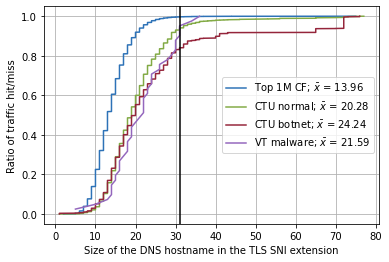

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import make_interp_spline

def plot_CDF(data1, label1, title, xlabel, ylabel, datas=[], labels=[], colors=[], save=None):
    # Sort the data in ascending order
    sorted_data1 = np.sort(data1)

    # Calculate the CDF values
    cdf1 = np.arange(1, len(sorted_data1) + 1) / len(sorted_data1)

    # Plot the CDF
    mean = round(sum(sorted_data1) / len(sorted_data1), 2)
    plt.plot(sorted_data1, cdf1, color='#2D72B7', label=label1 + r'; $\bar{x}$ = ' + str(mean))
    if datas != []:
        sorted_datas = []
        cdfs = []
        i = 0
        for data in datas:
            sorted_data = np.sort(data)
            mean = round(sum(sorted_data) / len(sorted_data), 2)
            # sorted_datas.append(sorted_data)
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            
            plt.plot(sorted_data, cdf, label=labels[i] + r'; $\bar{x}$ = ' + str(mean) , color=colors[i])
            
            i += 1
            
    plt.axvline(x=31, color='black')
            
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='center right')
    plt.grid(True)
    if save != None:
        plt.savefig(save, format="pdf", bbox_inches="tight")
    plt.show()

def collect_servernames(ssl_log, servernames_list: list, nb_tls_flows: list):
    '''
    https://docs.zeek.org/en/lts/scripts/base/protocols/ssl/main.zeek.html
    '''
    with open(ssl_log) as fr:
        for line in fr:
            if line.startswith("#"):
                continue
                
            nb_tls_flows[0] += 1            
            fields = line.split("	")
            server_name = fields[9]
            if server_name not in servernames_list:
                servernames_list.append(server_name)
                
    return nb_tls_flows

def analyze_servernames(directory):
    servernames_list = []
    nb_tls_flows = [0]
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith("ssl.log") or "ssl_ctu" in file:
                abs_path = os.path.join(subdir, file)
                
                collect_servernames(abs_path, servernames_list, nb_tls_flows)
                
    return servernames_list, nb_tls_flows

if __name__ == "__main__":
    N = 31
    
    # Top1m Cloudflare 
    top1m_cf_lens = []
    fr = open('./Data/Processed/Top1m_cloudflare/cloudflare-radar-domains-top-1000000-20240311-20240318.csv')
    i = 0
    gr = 0
    for l in fr:
        i += 1
        if i == 1:
            continue
        l = l.strip()
        if len(l) > N:
            gr += 1
        top1m_cf_lens.append(len(l)) 
        
    print("Top1m CF Domains (total=%s)> %s: %f" \
          %(len(top1m_cf_lens), N, gr/len(top1m_cf_lens)*100))
    mean = sum(top1m_cf_lens) / len(top1m_cf_lens) 
    variance = sum([((x - mean) ** 2) for x in top1m_cf_lens]) / len(top1m_cf_lens) 
    std = variance ** 0.5
    print("\tMean = %f\n\tStd = %f" %(mean, std))
    
#     Top1m Cisco Umbrella 
#     top1m_cu_lens = []
#     fr = open('./Data/Processed/Top1m_cisco/top-1m.csv')
#     i = 0
#     gr = 0
#     for l in fr:
#         l = l.strip()
#         l = l.split(",")[1]
#         if len(l) > N:
#             gr += 1
#         top1m_cu_lens.append(len(l)) 
        
#     print("Top1m CU Domains (total=%s)> %s: %f" \
#           %(len(top1m_cu_lens), N, gr/len(top1m_cu_lens)*100))
        
    
    # CTU Normal Dataset
    directory = "./Data/Processed/Benign/"
    if 'servernames_list_normal' not in locals() or 'nb_tls_flows' not in locals() :
        servernames_list_normal, nb_tls_flows = analyze_servernames(directory)
    gr = 0
    for servername in servernames_list_normal:
        if len(servername) > N:
            gr += 1
    print("Benign Servernames (total=%s)> %s: %f" \
          %(len(servernames_list_normal), N, gr/len(servernames_list_normal)*100))
    print("\tCTU normal dataset, total number of TLS flows (using zeek) = %d\n\tCTU normal dataset, total number of distinct TLS SNI DNS hostname (using zeek) = %d" \
         %(nb_tls_flows[0], len(servernames_list_normal)) )
    
    servername_lens_list_normal = [len(e) for e in servernames_list_normal]
    
    mean = sum(servername_lens_list_normal) / len(servername_lens_list_normal) 
    variance = sum([((x - mean) ** 2) for x in servername_lens_list_normal]) / len(servername_lens_list_normal) 
    std = variance ** 0.5
    print("\tMean = %f\n\tStd = %f" %(mean, std))
    
    # plot_CDF(data1=servername_lens_list_normal, label1="Normal")
    
    
    
    # '''
    # Malware directory (CTU botnets)
    directory = "./Data/Processed/Malicious/zeek_output_botnet/"
    if 'servernames_list_malware_ctu' not in locals():
        servernames_list_malware_ctu, nb_tls_flows = analyze_servernames(directory)
    gr = 0
    for servername in servernames_list_malware_ctu:
        if len(servername) > N:
            gr += 1
            
    print("Botnet (CTU) Servernames (total=%s)> %s: %f" \
          %(len(servernames_list_malware_ctu), N, gr/len(servernames_list_malware_ctu)*100))
    print("\tBotnet (CTU) dataset, total number of TLS flows (using zeek) = %d\n\tCTU normal dataset, total number of distinct TLS SNI DNS hostname (using zeek) = %d" \
         %(nb_tls_flows[0], len(servernames_list_malware_ctu)) )
    
    servername_lens_list_malware_ctu = [len(e) for e in servernames_list_malware_ctu]

    mean = sum(servername_lens_list_malware_ctu) / len(servername_lens_list_malware_ctu) 
    variance = sum([((x - mean) ** 2) for x in servername_lens_list_malware_ctu]) / len(servername_lens_list_malware_ctu) 
    std = variance ** 0.5
    print("\tMean = %f\n\tStd = %f" %(mean, std))
    
    
    # Malware directory (VirusTotal)
    directory = "./Data/Processed/Malicious/zeek_output_malware/"
    if 'servernames_list_malware_vt' not in locals():
        servernames_list_malware_vt, nb_tls_flows = analyze_servernames(directory)
    gr = 0
    for servername in servernames_list_malware_vt:
        if len(servername) > N:
            gr += 1
    print("Botnet (VirusTotal) Servernames (total=%s)> %s: %f" \
          %(len(servernames_list_malware_vt), N, gr/len(servernames_list_malware_vt)*100))
    print("\tBotnet (VirusTotal) dataset, total number of TLS flows (using zeek) = %d\n\tCTU normal dataset, total number of distinct TLS SNI DNS hostname (using zeek) = %d" \
         %(nb_tls_flows[0], len(servernames_list_malware_vt)) )
    
    servername_lens_list_malware_vt = [len(e) for e in servernames_list_malware_vt]
    
    mean = sum(servername_lens_list_malware_vt) / len(servername_lens_list_malware_vt) 
    variance = sum([((x - mean) ** 2) for x in servername_lens_list_malware_vt]) / len(servername_lens_list_malware_vt) 
    std = variance ** 0.5
    print("\tMean = %f\n\tStd = %f" %(mean, std))
    
    # plotting
    plot_CDF(data1=top1m_cf_lens, label1="Top 1M CF" "", 
             # data1=top1m_cu_lens, label1="Top 1M CU", 
             title="",
             xlabel="Size of the DNS hostname in the TLS SNI extension",
             ylabel="Ratio of traffic hit/miss",
             datas=[servername_lens_list_normal, servername_lens_list_malware_ctu, servername_lens_list_malware_vt],
             labels=["CTU normal", "CTU botnet", "VT malware"],
             colors=["#82AA45", "#95253B", "tab:purple"],
             save="servername_analysis/servername_size_ratio.pdf"
            )
    # '''
